# Differentially Private Point Patterns with GANs

## Setup

Install / load required dependencies

In [1]:
from IPython.display import clear_output
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import cuda, FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader

import datetime
import sys
import requests
import io
import os
import random
from time import sleep

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [2]:
# Use GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Connect to GDrive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!if [ -d 'gdrive/My Drive/PNGAN/model']; then echo "Directory train already exist" ; else mkdir -p 'gdrive/My Drive/PNGAN/model' && echo "Directory train created"; fi

/bin/bash: line 0: [: missing `]'
Directory train created


## Data

Read data; Options are:
* `"porto"` (2D)
* `"new_york"` (2D)
* `"beijing"` (2D)
* `"3d_road"` (3D)

In [10]:
### CHOSE DATASET YOU WANT TO USE
dataset = "3d_road" # chose from ["porto","new_york,"beijing","3d_road"]
###

if dataset == "porto":
  url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/porto-test.csv"
elif dataset == "new_york":
  url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/nyc-test.csv"
elif dataset == "beijing":
  url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/beijing-test.csv"
elif dataset == "3d_road":
  url="https://archive.ics.uci.edu/ml/machine-learning-databases/00246/3D_spatial_network.txt"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

if dataset == "3d_road":
  c.columns = ["id","x","y","z"]
  c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
  c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
  c["z"] = 2 * (c["z"]-min(c["z"]))/(max(c["z"])-min(c["z"])) - 1
  c = c[["x","y","z"]]
else:
  c.columns = ["x","y"]
  c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
  c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1

data_scaled = c

Plot data

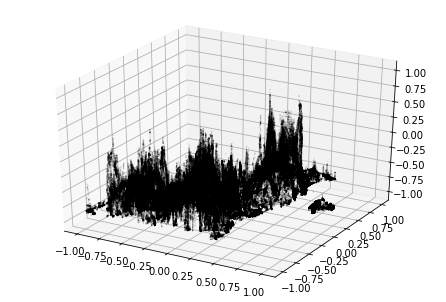

In [11]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

if dataset == "3d_road":
  fig = pyplot.figure()
  ax = Axes3D(fig)

  ax.scatter(c[["x"]],c[["y"]],c[["z"]], s = 0.01, c="black")

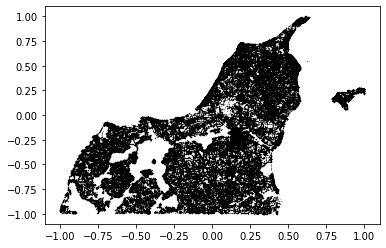

In [12]:
plt.scatter(c[["x"]],c[["y"]], s = 0.01, c="black")

### GeoPointGAN - Code Base

In [13]:
###
# Large Spatial Transformer Network (STN) module
# 
# Input:
#   k = number of point dimensions
###
class STNkd(nn.Module):
    def __init__(self, k=2):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 32, 1)
        self.conv2 = torch.nn.Conv1d(32, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, 512, 1)
        self.conv5 = torch.nn.Conv1d(512, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)
        self.bn8 = nn.BatchNorm1d(128)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.fc2(x)))
        x = F.relu(self.bn8(self.fc3(x)))
        x = self.fc4(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)

        return x

###
# PointNet encoder
#
# Input:
#   code_nfts = number of point embedding dimensions
#   num_points = number of points 
#   n_dim = number of point dimensions
#   global_feat = if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNetfeat(nn.Module):
    """
        PointNet Module
    """
    def __init__(self, code_nfts=2048, num_points=2500, n_dim = 2, global_feat=True, trans=True):
        super(PointNetfeat, self).__init__()
        self.n_dim = n_dim
        self.stn = STNkd(k = n_dim)
        self.code_nfts = code_nfts
        self.conv1 = torch.nn.Conv1d(n_dim, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, code_nfts, 1)

        self.bn1 = torch.nn.BatchNorm1d(64)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(code_nfts)
        self.trans = trans

        self.num_points = num_points
        self.global_feat = global_feat

    def forward(self, x):
        if self.trans:
            trans = self.stn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans)
            x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x,_ = torch.max(x, 2)
        x = x.view(-1, self.code_nfts)
        if self.trans:
            if self.global_feat:
                return x #, trans
            else:
                x = x.view(-1, self.code_nfts, 1).repeat(1, 1, self.num_points)
                return torch.cat([x, pointfeat], 1), trans
        else:
            return x

###
# PointNet Generator
#
# Input:
#   code_nfts = number of point embedding dimensions
#   n_dim = number of point_dimensions
#   global_feat = argument for PointNet: if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = argument for PointNet: if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNet_Generator(nn.Module):
    """ 
        Generator with PointNet Encoder, MLP Decoder
    """
    def __init__(self, code_nfts=2048, n_dim=2, global_feat=True, trans=True):
        super(PointNet_Generator, self).__init__()
        self.code_nfts = code_nfts
        self.n_dim = n_dim
        self.encoder = nn.Sequential(
            PointNetfeat(code_nfts, 1, n_dim = n_dim, global_feat=global_feat, trans=trans),
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU(),
            nn.Linear(code_nfts, code_nfts // 2),
            nn.BatchNorm1d(code_nfts // 2),
            nn.ReLU(),
            nn.Linear(code_nfts // 2, n_dim),
            nn.Tanh()
        )


    def forward(self, x):
        #Encoder
        code = self.encoder(x)
        #Decoder
        x = self.decoder(code)
        x = x.view(-1, self.n_dim, 1)
        return x, code

###
# PointNet Discriminator
#
# Input:
#   code_nfts = number of point embedding dimensions
#   n_dim = number of point dimensions
#   global_feat = argument for PointNet: if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = argument for PointNet: if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNet_Discriminator(nn.Module):
    """ 
        PointNet Discriminator
    """
    def __init__(self, code_nfts=2048, n_dim = 2, global_feat=True, trans = False):
        super(PointNet_Discriminator, self).__init__()
        self.n_dim = n_dim
        self.code_nfts = code_nfts
        self.cls = nn.Sequential(
            PointNetfeat(code_nfts, 1, n_dim = n_dim, global_feat=global_feat, trans=trans),
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU(),
            nn.Linear(code_nfts, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        #Point level classifier
        x = self.cls(x)
        return x

Utilities

In [14]:
#Plotting
def get_sample_points(G, z, n_dim = 2):
    """
      Generate 'size' data samples
      ___

      G = Generator (in G.eval() mode)
      z = Random noise tensor of shape (n, 2, 1)
      n = number of points
    """
    z_gen,_ = G(z)
    z_gen = z_gen.permute(2,0,1)
    n = z_gen.shape[1]
    batch_size = z_gen.shape[0]
    y_hat = z_gen.reshape(n * batch_size, n_dim) 
    points = y_hat.cpu().data.numpy()
    return points

#Probability calculator with privacy budget
from math import e
def dp_proba(eps, d):
  p = (e**eps) / (e**eps + d - 1)
  q = 1 / (e**eps + d - 1)
  return p, q

## Training

Enter the desired training configuration

In [15]:
### TRAINING CONFIGURATION
torch.manual_seed(99) # Initiate random seed
# TRAINING DATA
draw_with_replacement = False #Draw with replacement or not
n_samples = 10000 # Number of random draws from the real points
num_points = 7500 # Number of drawn points
# TRAINING UTILITIES
enable_plotting = True # Plot GAN samples every 500 steps
save_model_step = True # Save models (D,G) to drive every 500 steps (requires mounted Google Drive)
warm_start = False # Continue training of existing models (requires mounted Google drive with models)
# TRAINING CONFIG
num_epochs = 10 # Number of training epochs 
embed_dim_d = 256 # Number of point embedding dimensions for Discriminator
embed_dim_g = 256 # Number of point embedding dimensions for Generator
d_train = 1 # How many more training steps for Discriminator than Generator (1 = equal training)
label_flip = False #Randomly flip GAN labels to train a DP Generator
eps = 3 #Define privacy budget (only if label_flip = True)
###

# PROVEN BEST SETTING:
# num_epochs = 10
# n_samples = 10000
# num_points = 7500
# embed_dim_d = 256
# embed_dim_g = 256
# 
#
# Initialize D and G optimizer
# D_opt = torch.optim.AdamW(D.parameters(), lr=0.00004, betas=(0.5, 0.999))
# G_opt = torch.optim.AdamW(G.parameters(), lr=0.00004, betas=(0.5, 0.999))
# scheduler_D = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3000,50000,90000], gamma=0.1)
# scheduler_G = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3000,50000,90000], gamma=0.1)

Train GAN:

<Figure size 432x288 with 0 Axes>

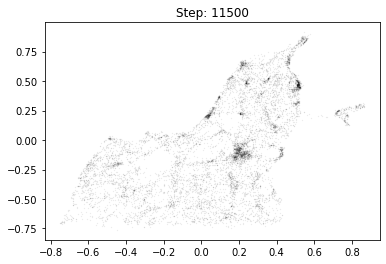

Epoch 2 [1500/10000] - G Loss: 0.779 - D Loss: 1.376 - Learning rate: 0.000004
Epoch 2 [1600/10000] - G Loss: 0.778 - D Loss: 1.376 - Learning rate: 0.000004
Epoch 2 [1700/10000] - G Loss: 0.779 - D Loss: 1.376 - Learning rate: 0.000004
Epoch 2 [1800/10000] - G Loss: 0.779 - D Loss: 1.376 - Learning rate: 0.000004
Epoch 2 [1900/10000] - G Loss: 0.779 - D Loss: 1.376 - Learning rate: 0.000004


KeyboardInterrupt: ignored

In [16]:
%matplotlib inline

#Set dimensionality
if dataset == "3d_road":
  n_dim = 3
else:
  n_dim = 2
#Generate training samples by drawing random samples from the real data
total_num_points = len(data_scaled["x"]-1)
data = torch.zeros(n_samples,num_points,n_dim)
for i in range(n_samples-1):
  if draw_with_replacement:
    idx = np.random.randint(low=0,high=total_num_points, size=num_points) # Draw with replacement
  else:
    idx = np.random.choice(total_num_points, num_points) # Draw without replacement
  sample = data_scaled.iloc[idx]
  sample = sample.to_numpy().reshape(num_points,n_dim)
  data[i,:,:] = torch.tensor(sample)
train_data = torch.tensor(data)
# Define data loader
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)

#Define DP probabilities
p, q = dp_proba(eps, 2)
if label_flip == False:
  eps = -1

# Define G and D
if warm_start:
  D = torch.load('gdrive/My Drive/PNGAN/model/D.pkl.gz')
  G = torch.load('gdrive/My Drive/PNGAN/model/G.pkl.gz')
else:
  D = PointNet_Discriminator(code_nfts = embed_dim_d, n_dim = n_dim).to(DEVICE)
  G = PointNet_Generator(code_nfts = embed_dim_g, n_dim = n_dim).to(DEVICE)
# Loss criterion
criterion = nn.BCELoss()
# Initialize D and G optimizer
D_opt = torch.optim.AdamW(D.parameters(), lr=0.00004, betas=(0.5, 0.999))
G_opt = torch.optim.AdamW(G.parameters(), lr=0.00004, betas=(0.5, 0.999))
scheduler_D = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3000,50000,90000], gamma=0.1)
scheduler_G = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3000,50000,90000], gamma=0.1)
# Define fake and real point labels
D_labels = torch.ones([num_points, batch_size]).to(DEVICE) # Discriminator Label to real
D_labels = D_labels - 0.1 # Can skip that line - Just a trick known to work well with GANs
D_fakes = torch.zeros([num_points, batch_size]).to(DEVICE) # Discriminator Label to fake

gen_loss = []
disc_loss = []
check_step = []
step = 0 # Initiate training step
g_step = 0
if n_dim==3:
  z_img = torch.randn(10000, n_dim, batch_size).to(DEVICE) # Initialize random noise for generating images
else:
  z_img = torch.randn(total_num_points, n_dim, batch_size).to(DEVICE) # Initialize random noise for generating images

for e in range(num_epochs):
  # Within each iteration, we will go over each minibatch of data
  for minibatch_i, (x_batch) in enumerate(train_loader):
    # Get data
    x = x_batch.float().to(DEVICE)
    x = x.permute(1,2,0)
    # Get labels
    if label_flip==True:
      D_labels = torch.bernoulli(torch.tensor([p] * num_points)).reshape(num_points,1).to(DEVICE)
      D_labels = D_labels - 0.1 # Can skip that line - Just a trick known to work well with GANs
      D_fakes = torch.bernoulli(torch.tensor([q] * num_points)).reshape(num_points,1).to(DEVICE)
    #Train Discriminator
    for d in range(d_train): #Train Disc d_train steps over Generator
      x_outputs = D(x)
      z = torch.randn(num_points, n_dim, batch_size).to(DEVICE)
      z_gen, _ = G(z)
      z_gen = z_gen.reshape(num_points, n_dim, batch_size)
      z_outputs = D(z_gen)
      D_x_loss = criterion(x_outputs, D_labels)
      D_z_loss = criterion(z_outputs, D_fakes)
      D_loss = D_x_loss + D_z_loss 
      D.zero_grad()
      D_loss.backward()
      D_opt.step()
      scheduler_D.step()
    # Training Generator
    g_step += 1
    z = torch.randn(num_points, n_dim, batch_size).to(DEVICE)
    z_gen, _ = G(z)
    z_gen = z_gen.reshape(num_points, n_dim, batch_size)
    z_outputs = D(z_gen)
    G_z_loss = criterion(z_outputs, D_labels)
    G_loss = G_z_loss
    G.zero_grad()
    G_loss.backward()
    G_opt.step()
    scheduler_G.step()
    gen_loss.append(G_loss.item())
    disc_loss.append(D_loss.item())
    # Training utilities: Saving models, plotting and loss progression
    if save_model_step:
      if step % 500 == 0:
        torch.save(G,'gdrive/My Drive/PNGAN/model/G_%s_eps%i.pkl.gz' % (dataset, eps) )
        torch.save(D,'gdrive/My Drive/PNGAN/model/D_%s_eps%i.pkl.gz' % (dataset, eps) )
    if enable_plotting:
      if step % 500 == 0:
        with torch.no_grad():
          G.eval()
          exp_points = get_sample_points(G, z_img, n_dim)
          clear_output()
          plt.figure(0)
          fig = plt.figure()
          ax = fig.add_subplot(1, 1, 1)
          ax.scatter(exp_points[:,0],exp_points[:,1],s=0.1,alpha=0.1,c="black")
          ax.set_facecolor('white')
          ax.set_title('Step: %i' %step)
          plt.show()
          sleep(1)
          G.train()                    
    if step % 100 == 0:
      print('Epoch %d [%d/%d] - G Loss: %.3f - D Loss: %.3f - Learning rate: %.6f' % (e + 1, minibatch_i, len(train_loader), G_loss.item(), D_loss.item(), D_opt.param_groups[0]['lr']))
    # Increment step
    step = step + 1

## Plotting checks:

How does the generated data look like at the last training step?

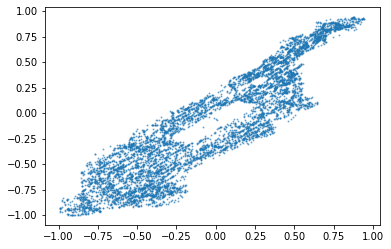

In [ ]:
plt.scatter(z_gen[:,0,:].detach().cpu().reshape(-1),z_gen[:,1,:].detach().cpu().reshape(-1),s=1,alpha=0.5)

How does the real data look in comparison? Quite similar!

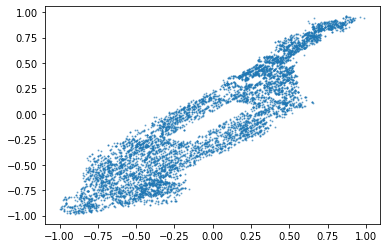

In [ ]:
plt.scatter(x[:,0,:].detach().cpu().reshape(-1),x[:,1,:].detach().cpu().reshape(-1),s=1,alpha=0.5)

Let's check the model losses:

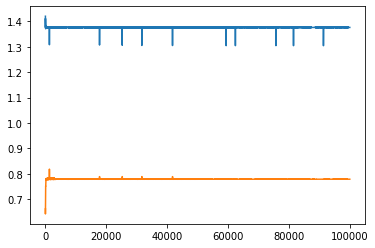

In [ ]:
plt.plot(range(len(disc_loss)), disc_loss)
plt.plot(range(len(gen_loss)), gen_loss)

Compute metrics

In [ ]:
!pip install chamferdist

  Created wheel for chamferdist: filename=chamferdist-1.0.0-cp36-cp36m-linux_x86_64.whl size=5132426 sha256=8c7d06890a78b6e82f7ced6b89419561cba187ca79df96e63d04e481f8bd3637
  Stored in directory: /root/.cache/pip/wheels/39/8b/71/6eb6de869c9e2b673d2afb970d5a35377f32c3f95cd726a8e3
Successfully built chamferdist


In [ ]:
import torch

min_var_est = 1e-8


# Consider linear time MMD with a linear kernel:
# K(f(x), f(y)) = f(x)^Tf(y)
# h(z_i, z_j) = k(x_i, x_j) + k(y_i, y_j) - k(x_i, y_j) - k(x_j, y_i)
#             = [f(x_i) - f(y_i)]^T[f(x_j) - f(y_j)]
#
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def linear_mmd2(f_of_X, f_of_Y):
    loss = 0.0
    delta = f_of_X - f_of_Y
    loss = torch.mean((delta[:-1] * delta[1:]).sum(1))
    return loss


# Consider linear time MMD with a polynomial kernel:
# K(f(x), f(y)) = (alpha*f(x)^Tf(y) + c)^d
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def poly_mmd2(f_of_X, f_of_Y, d=2, alpha=1.0, c=2.0):
    K_XX = (alpha * (f_of_X[:-1] * f_of_X[1:]).sum(1) + c)
    K_XX_mean = torch.mean(K_XX.pow(d))

    K_YY = (alpha * (f_of_Y[:-1] * f_of_Y[1:]).sum(1) + c)
    K_YY_mean = torch.mean(K_YY.pow(d))

    K_XY = (alpha * (f_of_X[:-1] * f_of_Y[1:]).sum(1) + c)
    K_XY_mean = torch.mean(K_XY.pow(d))

    K_YX = (alpha * (f_of_Y[:-1] * f_of_X[1:]).sum(1) + c)
    K_YX_mean = torch.mean(K_YX.pow(d))

    return K_XX_mean + K_YY_mean - K_XY_mean - K_YX_mean


def _mix_rbf_kernel(X, Y, sigma_list):
    assert(X.size(0) == Y.size(0))
    m = X.size(0)

    Z = torch.cat((X, Y), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)


def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)


def mix_rbf_mmd2_and_ratio(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)


################################################################################
# Helper functions to compute variances based on kernel matrices
################################################################################


def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2


def _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    mmd2, var_est = _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=const_diagonal, biased=biased)
    loss = mmd2 / torch.sqrt(torch.clamp(var_est, min=min_var_est))
    return loss, mmd2, var_est


def _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
        sum_diag2_X = sum_diag2_Y = m * const_diagonal**2
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)
        sum_diag2_X = diag_X.dot(diag_X)
        sum_diag2_Y = diag_Y.dot(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e
    K_XY_sums_1 = K_XY.sum(dim=1)                     # K_{XY} * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    Kt_XX_2_sum = (K_XX ** 2).sum() - sum_diag2_X      # \| \tilde{K}_XX \|_F^2
    Kt_YY_2_sum = (K_YY ** 2).sum() - sum_diag2_Y      # \| \tilde{K}_YY \|_F^2
    K_XY_2_sum  = (K_XY ** 2).sum()                    # \| K_{XY} \|_F^2

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    var_est = (
        2.0 / (m**2 * (m - 1.0)**2) * (2 * Kt_XX_sums.dot(Kt_XX_sums) - Kt_XX_2_sum + 2 * Kt_YY_sums.dot(Kt_YY_sums) - Kt_YY_2_sum)
        - (4.0*m - 6.0) / (m**3 * (m - 1.0)**3) * (Kt_XX_sum**2 + Kt_YY_sum**2)
        + 4.0*(m - 2.0) / (m**3 * (m - 1.0)**2) * (K_XY_sums_1.dot(K_XY_sums_1) + K_XY_sums_0.dot(K_XY_sums_0))
        - 4.0*(m - 3.0) / (m**3 * (m - 1.0)**2) * (K_XY_2_sum) - (8 * m - 12) / (m**5 * (m - 1)) * K_XY_sum**2
        + 8.0 / (m**3 * (m - 1.0)) * (
            1.0 / m * (Kt_XX_sum + Kt_YY_sum) * K_XY_sum
            - Kt_XX_sums.dot(K_XY_sums_1)
            - Kt_YY_sums.dot(K_XY_sums_0))
        )
    return mmd2, var_est

In [ ]:
x.shape

torch.Size([7500, 2, 1])

In [ ]:
from chamferdist import ChamferDistance
chamferDist = ChamferDistance()
cd = chamferDist(x.permute(2,0,1), z_gen.permute(2,0,1), bidirectional=True)
cd

tensor(1.0673, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
base = 1.0 #MMD settings
sigma_list = [1, 2, 4, 8, 16]
sigma_list = [sigma / base for sigma in sigma_list]
mmd = mix_rbf_mmd2(x.reshape(num_points,n_dim), z_gen.reshape(num_points,n_dim), sigma_list=sigma_list)
mmd

tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)